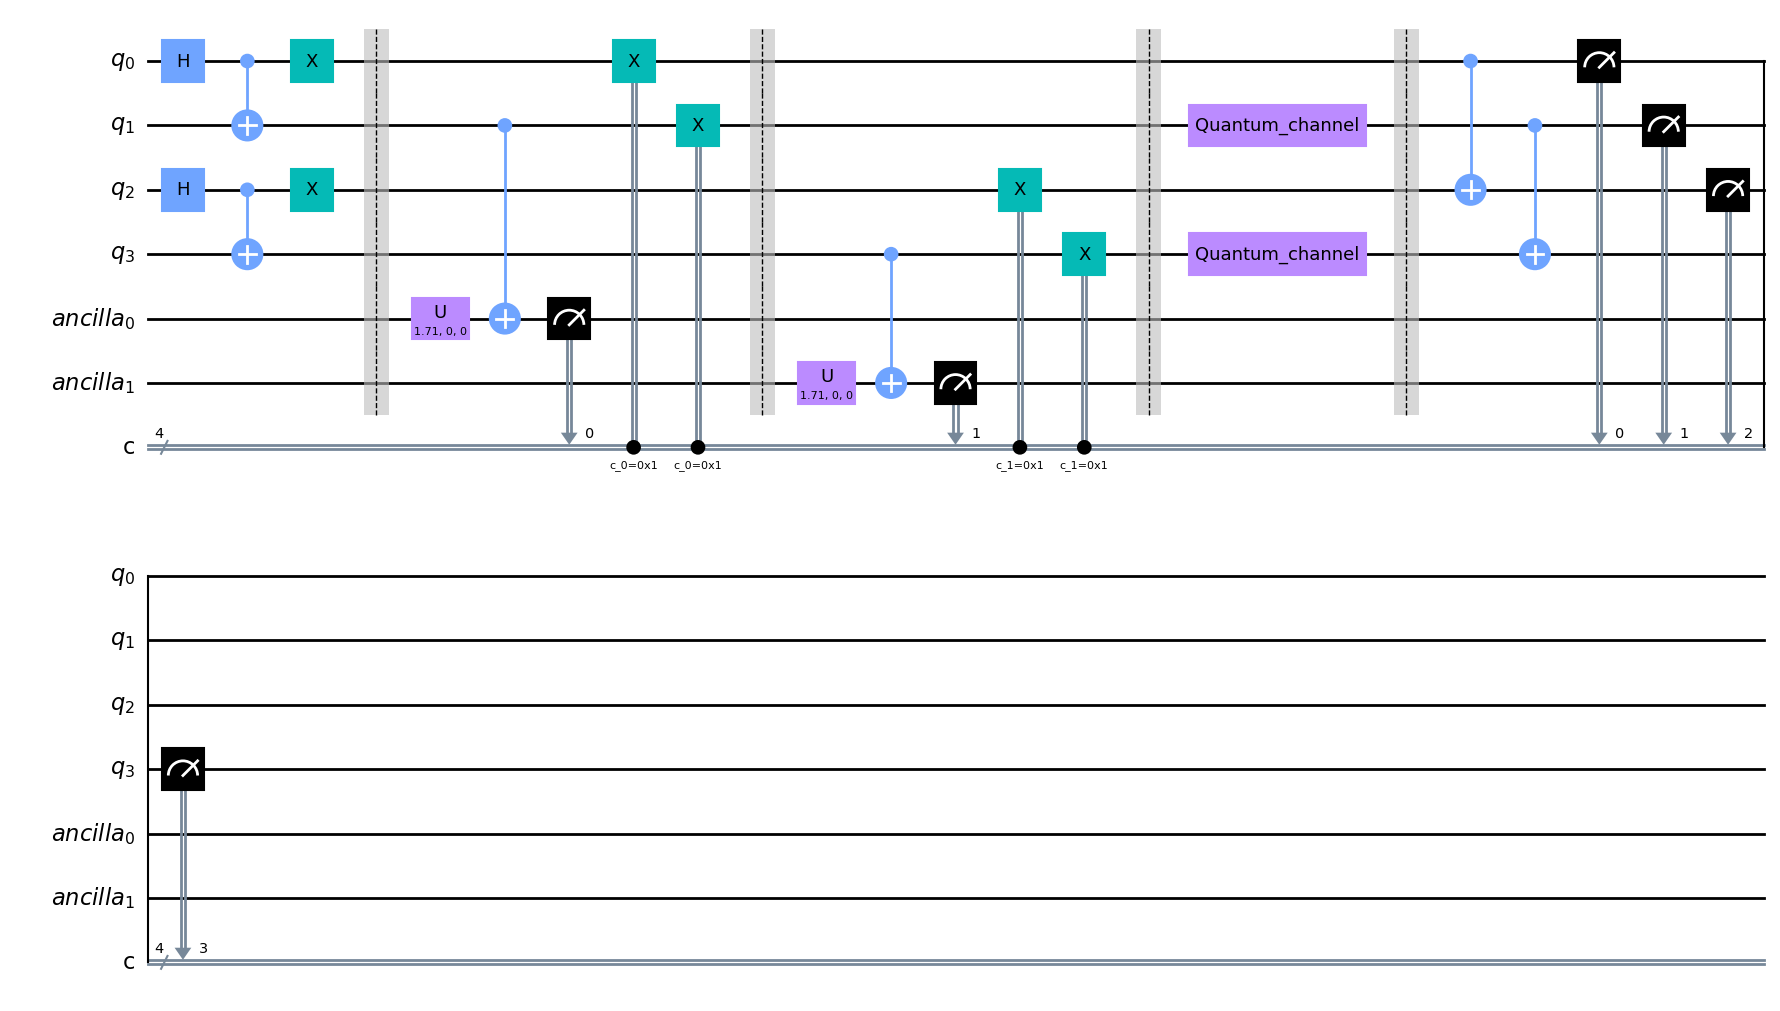

In [4]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute, Aer,transpile, assemble
from qiskit.quantum_info import Kraus, SuperOp, Operator, partial_trace, DensityMatrix
from qiskit.visualization import plot_bloch_multivector, plot_state_city
from qiskit.providers.aer.noise import amplitude_damping_error, NoiseModel, depolarizing_error, ReadoutError
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
import numpy as np

# Define the damping parameter for the amplitude damping channel
r = 0.25

### The circuit to creat a Bell state
qcb = QuantumCircuit(2)
qcb.h(0)
qcb.cx(0, 1)
qcb.x(0)
Bell_circ=qcb.to_gate(label="Bell state")

##########

q = QuantumRegister(4, 'q')
anc = QuantumRegister(2, 'ancilla')
c = ClassicalRegister(4, 'c')
qc = QuantumCircuit(q, anc, c)

qc.h(0)
qc.cx(0, 1)
qc.x(0)

qc.h(2)
qc.cx(2, 3)
qc.x(2)

#qc.append(Bell_circ, [0,1])
#qc.append(Bell_circ, [2,3])
qc.barrier()

########## Measurement
#theta = Parameter('θ')
theta=2*np.arctan(1/np.sqrt(1-r))
qc.u(theta,0,0,anc[0])
qc.cx(q[1], anc[0])
qc.measure(anc[0],0)
#qc.barrier()
qc.x([0, 1]).c_if(c[0], 1)
qc.barrier()

###### Second pair
qc.u(theta,0,0,anc[1])
qc.cx(q[3], anc[1])
qc.measure(anc[1],1)
#qc.barrier()

qc.x([2, 3]).c_if(c[1], 1)

qc.barrier()
###### Defining amplitude damping channel:
error =amplitude_damping_error(r, excited_state_population=0, canonical_kraus=True)
qc.append(error, [1])
qc.append(error, [3])
qc.barrier()

#### Distillation
qc.cx(0, 2)
qc.cx(1, 3)
######################################
#readout error rate:
error_rate_eta=0

#Depolarizing error of CNOT gate:
error_rate_cnot =0 # Adjust this value based on the desired error rate

# Create a depolarizing error for the CNOT gate
cnot_error = depolarizing_error(error_rate_cnot, 2)


# Create a noise model and add the CNOT error to it for the specified qubits
noise_model = NoiseModel()
noise_model.add_quantum_error(cnot_error, 'cx', [0,1])
noise_model.add_quantum_error(cnot_error, 'cx', [2,3])
noise_model.add_quantum_error(cnot_error, 'cx', [1,4])
noise_model.add_quantum_error(cnot_error, 'cx', [3,5])
noise_model.add_quantum_error(cnot_error, 'cx', [0,2])
noise_model.add_quantum_error(cnot_error, 'cx', [1,3])
# Add custom readout error model to the existing noise model

eta= error_rate_eta# Adjust this value based on the desired readout error rate
error_meas_ancilla = ReadoutError([[1- eta, eta], [eta, 1- eta]])
noise_model.add_readout_error(error_meas_ancilla, [2])
noise_model.add_readout_error(error_meas_ancilla, [3]) 
noise_model.add_readout_error(error_meas_ancilla, [4]) 
noise_model.add_readout_error(error_meas_ancilla, [5]) 

####################################
qc.measure([0,1,2,3],[0,1,2,3])

qc.draw('mpl')

In [5]:
Shots_n=100000
method = "statevector"
backend = AerSimulator(method="statevector")
job = backend.run(qc, method=method,noise_model=noise_model, shots=Shots_n)  # Run the simulation
result = job.result()  # Get the simulation result

counts = result.get_counts()  # Get the measurement counts
print(counts)

{'0010': 18405, '1010': 6196, '0001': 18350, '1110': 18366, '0101': 6064, '1101': 18425, '1000': 6151, '0000': 1960, '0100': 6083}


success: 38715 , fail: 61285 , total: 100000
Bell states counts: {'0010': 18405, '0001': 18350, '0000': 1960}
Bell new: {'10': 18405, '01': 18350, '00': 1960}
probability of sucecess 0.38715
Fidelity= 0.949373096333632


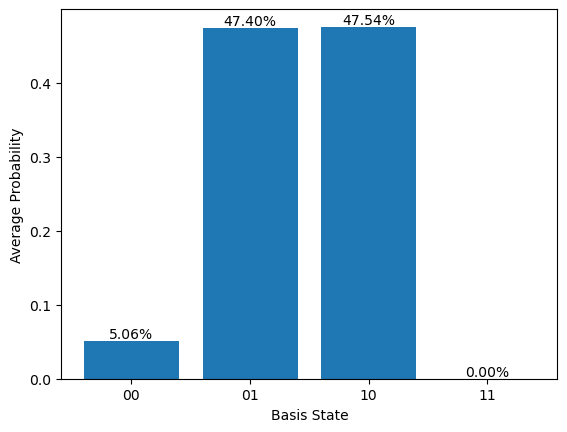

In [7]:
success, fail = 0, 0
Bell_states = {}
Bell_new = {}

for jj in counts:
    #if (jj[0] ==jj[1] ):
    if jj[0] == jj[1]=='0': #Consider the target pair in case of sacrificial qubit measurement result '1' ('0') 
        success += counts[jj]
        Bell_state = jj
        if Bell_state in Bell_states:
            Bell_states[Bell_state] += counts[jj]
        else:
            Bell_states[Bell_state] = counts[jj]
    else:
        fail += counts[jj]

total = success + fail

# Extract the target qubits state and store it in Bell_new as a dictionary
for i in Bell_states:
    last_char = i[2:]
    if last_char in Bell_new:
        Bell_new[last_char] += Bell_states[i]
    else:
        Bell_new[last_char] = Bell_states[i]

print('success:', success, ',', 'fail:', fail, ',', 'total:', total)
print('Bell states counts:', Bell_states)
print('Bell new:', Bell_new)
print('probability of sucecess',success/(total))

# Convert counts to a sorted list of probabilities
basis_states = ['00', '01', '10', '11']
probabilities = [Bell_new.get(state, 0) / success for state in basis_states]
prob_01 = probabilities[basis_states.index('01')]
prob_10 = probabilities[basis_states.index('10')]
fid=1/2*(prob_01+prob_10)+np.sqrt(prob_01*prob_10)
print('Fidelity=',fid)


# Plot the probabilities as a bar graph
plt.bar(basis_states, probabilities)
plt.xlabel('Basis State')
plt.ylabel('Average Probability')
#plt.title(f'Average Probability of Basis States for Target Pair (r={r})')
# Add percentage labels on top of each bar
for i, prob in enumerate(probabilities):
    plt.text(basis_states[i], prob, f'{prob * 100:.2f}%', ha='center', va='bottom')
plt.show()
